In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

In [ ]:
import random
random.seed(562023)

We load the dataset that are already shuffled, scaled, oversampled and without missing values:

In [ ]:
# Load the dataset from local drive
import pandas as pd
import io
from google.colab import files

# training set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['train_set_mice.csv']))
train_set = pd.DataFrame(data=data)

Saving train_set_mice.csv to train_set_mice.csv


In [ ]:
# test set
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['test_set_mice.csv']))
test_set = pd.DataFrame(data=data)

Saving test_set_mice.csv to test_set_mice.csv


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Dropping variables not needed:

In [ ]:
X_train = train_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA', 'Target'], axis=1)
y_train = train_set.Target
X_test = test_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA', 'Target'], axis=1)
y_test = test_set.Target

We define the measure to take into account the trade off that we want to achieve for this specific problem.

In [ ]:
def OurMeasfun(confmat):
  total = sum(sum(confmat))
  accuracy = (confmat[0,0] + confmat[1,1]) / total
  sensitivity = confmat[1,1] / (confmat[1,0] + confmat[1,1])
  specificity = confmat[0,0] / (confmat[0,0] + confmat[0,1])
  precision = confmat[1,1] / (confmat[1,1] + confmat[0,1])
  OurMeas = specificity*0.2+sensitivity*0.5+precision*0.3

  return OurMeas



# STEPWISE LOGISTIC REGRESSION FROM THE RANDOM FOREST MOST IMPORTANT FEATURES:

We write in a list the most usefull features of the dataset according to the random forest model:

In [ ]:
sorted_variable_namesRF = ['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST', 'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11', 'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST',
'ZSN_A', 'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11', 'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01',
'MP_TP_POST', 'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD', 'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB',
'FK_STENOK', 'INF_ANAM', 'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P', 'ALT_BLOOD', 'n_p_ecg_p_12',
'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX', 'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE', 'S_AD_ORIT', 'TIME_B_S']
sorted_variable_namesRF.reverse()
print(sorted_variable_namesRF)

['TIME_B_S', 'S_AD_ORIT', 'AGE', 'D_AD_ORIT', 'ant_im', 'NITR_S', 'lat_im', 'ROE', 'IBS_POST', 'SEX', 'ritm_ecg_p_01', 'ANT_CA_S_n', 'n_p_ecg_p_12', 'ALT_BLOOD', 'IM_PG_P', 'STENOK_AN', 'zab_leg_02', 'ASP_S_n', 'DLIT_AG', 'NA_BLOOD', 'INF_ANAM', 'FK_STENOK', 'GB', 'inf_im', 'AST_BLOOD', 'ritm_ecg_p_07', 'K_BLOOD', 'post_im', 'LID_S_n', 'GEPAR_S_n', 'n_r_ecg_p_01', 'MP_TP_POST', 'endocr_01', 'zab_leg_01', 'zab_leg_03', 'n_p_ecg_p_08', 'nr_11', 'n_r_ecg_p_03', 'n_p_ecg_p_07', 'nr_02', 'endocr_02', 'ZSN_A', 'O_L_POST', 'SIM_GIPERT', 'SVT_POST', 'n_r_ecg_p_08', 'n_p_ecg_p_11', 'B_BLOK_S_n', 'n_p_ecg_p_03', 'nr_04', 'TRENT_S_n', 'n_r_ecg_p_05', 'n_p_ecg_p_10', 'ritm_ecg_p_08', 'n_p_ecg_p_06', 'K_SH_POST', 'FIB_G_POST', 'ritm_ecg_p_02', 'n_r_ecg_p_06']


In [ ]:
len(sorted_variable_namesRF)

59

In [ ]:
IterVec = np.arange(1,len(sorted_variable_namesRF))

Stepwise logistic regression: at every iteration we add an other variable from the list and compute in cross validation the performance of the model.

In [ ]:
# Parameters
K = 5
# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
OM = np.zeros(shape=K)
accuracy = []
sensitivity = []
specificity = []
precision = []
our_measure = []

for it in IterVec:
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    X_val = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    # Building and training a Logistic Regression model
    log_reg = LogisticRegression(random_state=12345, max_iter=1000) # logistic regression
    VarSelezionate = sorted_variable_namesRF[:it] # select only variables untill it (at every iteration the number grows)
    log_reg.fit(train[VarSelezionate],y_t)   # building the model on the selected variables

    # Predicting values
    predicted_values = log_reg.predict_proba(X_val[VarSelezionate])[:, 1]
    y_pred = np.zeros(predicted_values.shape)
    y_pred[predicted_values > 0.5] = 1 # here we change the threshold as we want

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, y_pred)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])
    OM[k] = OurMeasfun(cm)

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy.append(acc.mean())
  sensitivity.append(sens.mean())
  specificity.append(spec.mean())
  precision.append(prec.mean())
  our_measure.append(OM.mean())

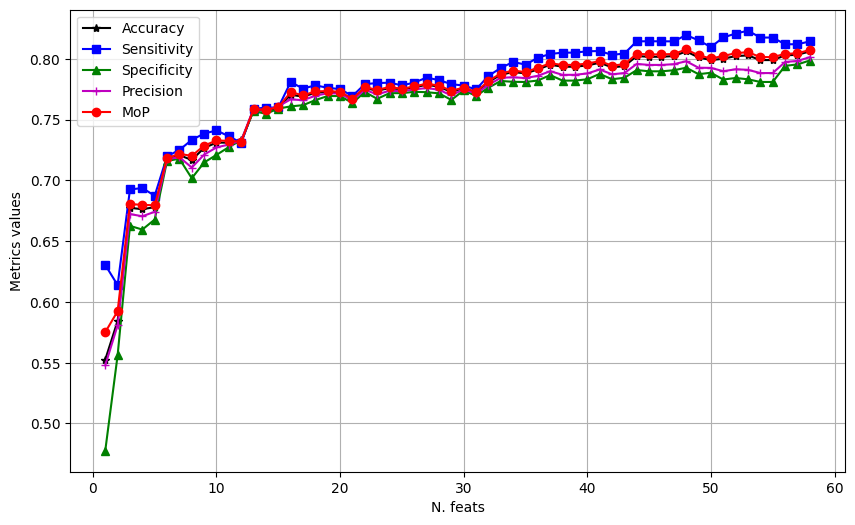

In [ ]:
# Plots
plt.plot(IterVec, accuracy, 'k*-', label='Accuracy')
plt.plot(IterVec, sensitivity, 'bs-', label='Sensitivity')
plt.plot(IterVec, specificity, 'g^-', label='Specificity')
plt.plot(IterVec, precision, 'm+-', label='Precision')
plt.plot(IterVec, our_measure, 'ro-', label='MoP')
plt.xlabel('N. feats')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

From the plot we see that the elbow of the performance is near 20 features, so from now on we consider those 20 most important variables and not all the rest. This process of feature selection allows us to have an easier model without losing too much on the performance side.

We evaluate now the model on the test set:

Accuracy on the test set:  0.7730192719486081
Sensitivity (fraction of true positive on all positives):  0.7857142857142857
Specificity (fraction of true negative on all negatives):  0.7707808564231738
Precision (fraction of true positive on all classified positive):  0.3767123287671233
MoP:  0.6600270127719147


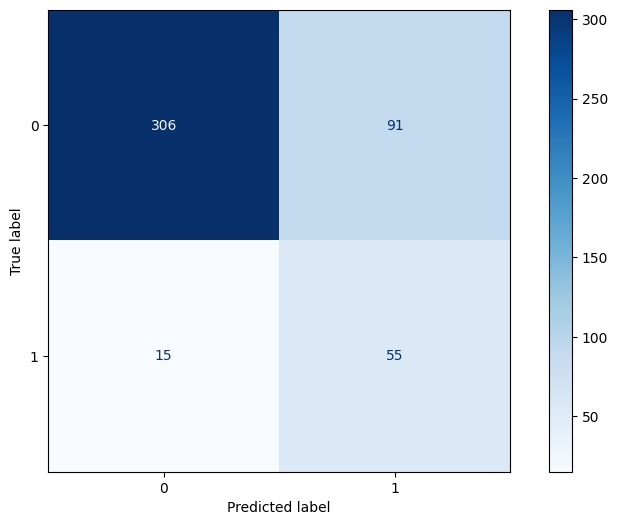

In [ ]:
it = 20
log_reg = LogisticRegression(random_state=12345, max_iter=1000)
VarSelezionate = sorted_variable_namesRF[:it]
log_reg.fit(train[VarSelezionate],y_t)
predicted_values = log_reg.predict_proba(X_test[VarSelezionate])[:, 1]
predicted_class = np.zeros(predicted_values.shape)

predicted_class[predicted_values > 0.5] = 1
y_pred = predicted_class
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = log_reg.classes_)
disp.plot(cmap='Blues')

total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ", precision)
our_measure = OurMeasfun(cm)
print("MoP: ", our_measure)


#Threshold
We refine now the threshold (that was as default 0.5) to go in the direction of our goal of having an high sensitivity.

In [ ]:
# K-fold CV
K = 5
# Thresholds to determine if a predicted value falls in class 0 or 1
threshold = np.arange(0.1, 0.9, 0.01)
# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
# TP/(TP+FP)
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
accuracy = np.zeros(shape=len(threshold))
sensitivity = np.zeros(shape=len(threshold))
specificity = np.zeros(shape=len(threshold))
precision = np.zeros(shape=len(threshold))
our_measure = np.zeros(shape=len(threshold))
OurMaxMeas = 0


In [ ]:
# K-fold CV
for i in range(0, len(threshold)):
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    validation = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    predicted_values = log_reg.predict_proba(X_test[VarSelezionate])[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    # Predicting values
    predicted_values = log_reg.predict_proba(validation[VarSelezionate])[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    predicted_class[predicted_values > threshold[i]] = 1

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, predicted_class)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy[i] = acc.mean()
  sensitivity[i] = sens.mean()
  specificity[i] = spec.mean()
  precision[i] = prec.mean()
  our_measure[i] = OurMeasfun(cm)
  if (our_measure[i] > OurMaxMeas): # We find the threshold that maximize our Performance Measure
    thrMax = threshold[i]
    OurMaxMeas = our_measure[i]

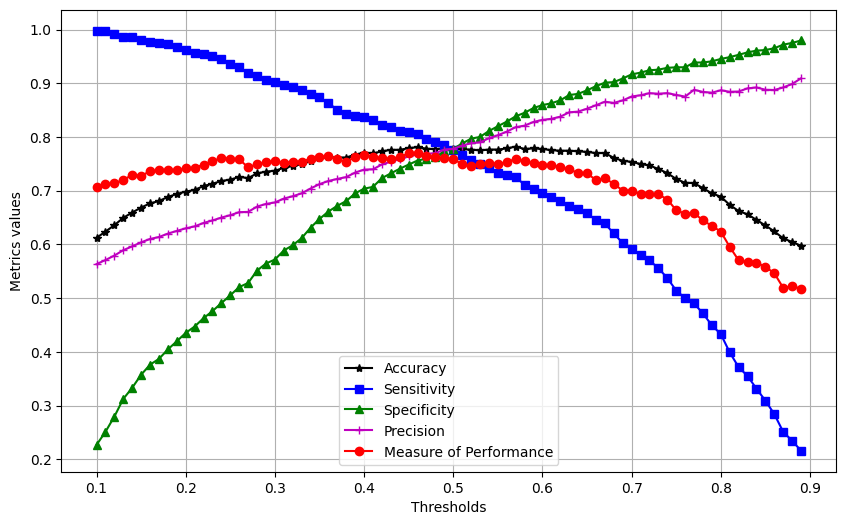

In [ ]:
# Plots
plt.plot(threshold, accuracy, 'k*-', label='Accuracy')
plt.plot(threshold, sensitivity, 'bs-', label='Sensitivity')
plt.plot(threshold, specificity, 'g^-', label='Specificity')
plt.plot(threshold, precision, 'm+-', label='Precision')
plt.plot(threshold, our_measure, 'ro-', label='Measure of Performance')
plt.xlabel('Thresholds')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

From the previous graph we find the maximum of the performance measure and the corresponding threshold is 0.45.

In [ ]:
print(OurMaxMeas,thrMax)

0.7697165621734586 0.44999999999999984


Accuracy on the test set:  0.7387580299785867
Sensitivity (fraction of true positive on all positives):  0.8142857142857143
Specificity (fraction of true negative on all negatives):  0.72544080604534
Precision (fraction of true positive on all classified positive):  0.3433734939759036
GabriMeas:  0.6552430665446962


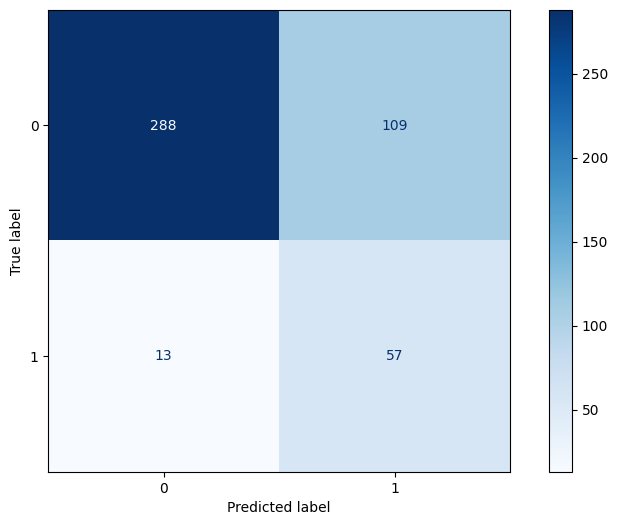

In [ ]:
log_reg = LogisticRegression(random_state=12345, max_iter=1000)
VarSelezionate = sorted_variable_namesRF[:it]
log_reg.fit(train[VarSelezionate],y_t)
predicted_values = log_reg.predict_proba(X_test[VarSelezionate])[:, 1]
predicted_class = np.zeros(predicted_values.shape)

predicted_class[predicted_values > thrMax] = 1
y_pred = predicted_class
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels = log_reg.classes_)
disp.plot(cmap='Blues')

total = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / total
print("Accuracy on the test set: ", accuracy)
sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
print("Sensitivity (fraction of true positive on all positives): ", sensitivity)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Specificity (fraction of true negative on all negatives): ", specificity)
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Precision (fraction of true positive on all classified positive): ", precision)
OurMeas = OurMeasfun(cm)
print("GabriMeas: ", OurMeas)


In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score

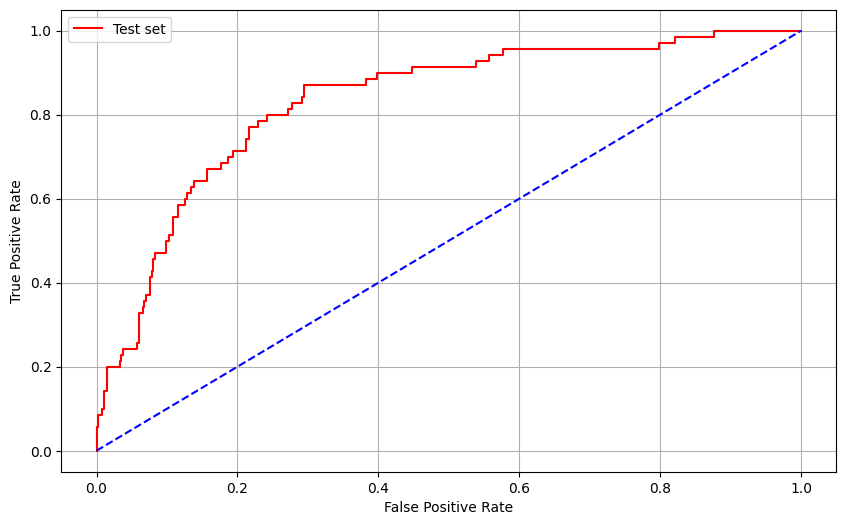

In [ ]:
# ROC curve function
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test[VarSelezionate])[:,1])
plt.plot(fpr, tpr, 'r-', label='Test set')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# AUC = area under the ROC curve
print("AUC for the logistic regression model on the test set: ", roc_auc_score(y_test,y_pred))

AUC for the logistic regression model on the test set:  0.7698632601655272


In [ ]:
from sklearn.metrics import log_loss

# AIC = Akaike information criterion
predicted_values = log_reg.predict_proba(X_test[VarSelezionate])[:,]

# Compute the log-likelihood
log_likelihood = -log_loss(y_test, predicted_values)

# Get the number of parameters (including the intercept)
coef = np.count_nonzero(log_reg.coef_)
num_params = coef + 1

# Compute the AIC
aic = -2 * log_likelihood + 2 * num_params
print("AIC:", aic)

AIC: 43.02974378558184
